#### Note: This is a simplified and more explainable version from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'hymenoptera_data'
#Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#Get the class names
class_names = image_datasets['train'].classes
#Print out the results 
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [4]:
#load the ResNet
model = torchvision.models.resnet18(pretrained= True)

In [5]:
#Load the ResNet
model_conv = torchvision.models.resnet18(pretrained=True)

In [7]:
model_conv.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [6]:
#Freeze all layers in the network  
for param in model_conv.parameters():  
    param.requires_grad = False

In [7]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [8]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [10]:
#Understand what's happening
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 1, 0, 0], device='cuda:0')
Output Tensor: tensor([[0.4293, 0.2459],
        [0.3408, 0.3232],
        [0.7665, 0.4813],
        [0.8241, 0.4909]], device='cuda:0', grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(2, device='cuda:0')


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
#This is to demonstrate what happens in the background of scheduler.step()
#No need to run this cell unless you want to create your own scheduler 
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [14]:
num_epochs = 25
for epoch in range (num_epochs):
    #Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images,labels in dataloaders['train']:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
        
    exp_lr_scheduler.step()    
    train_acc = 100 * correct / dataset_sizes['train']    
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.3f}%'
            .format(epoch+1, num_epochs, loss.item(), train_acc))

Epoch [1/25], Loss: 0.5000, Train Accuracy: 70.9016342163086%
Epoch [2/25], Loss: 0.2435, Train Accuracy: 80.73770141601562%
Epoch [3/25], Loss: 1.6287, Train Accuracy: 81.557373046875%
Epoch [4/25], Loss: 0.2728, Train Accuracy: 80.32786560058594%
Epoch [5/25], Loss: 0.1221, Train Accuracy: 82.78688049316406%
Epoch [6/25], Loss: 0.0880, Train Accuracy: 84.42622375488281%
Epoch [7/25], Loss: 1.1900, Train Accuracy: 79.91802978515625%
Epoch [8/25], Loss: 0.0271, Train Accuracy: 85.65573120117188%
Epoch [9/25], Loss: 0.2120, Train Accuracy: 83.60655212402344%
Epoch [10/25], Loss: 0.0061, Train Accuracy: 84.8360595703125%
Epoch [11/25], Loss: 0.2509, Train Accuracy: 86.06556701660156%
Epoch [12/25], Loss: 0.7578, Train Accuracy: 82.78688049316406%
Epoch [13/25], Loss: 0.0325, Train Accuracy: 86.06556701660156%
Epoch [14/25], Loss: 0.1751, Train Accuracy: 82.37704467773438%
Epoch [15/25], Loss: 0.1556, Train Accuracy: 86.47540283203125%
Epoch [16/25], Loss: 0.3985, Train Accuracy: 85.65573

In [15]:
# Test the model
model_conv.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 94.771 %


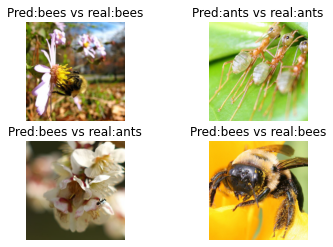

In [23]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Pred:{} vs real:{}'.format(class_names[preds[i]],class_names[labels[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)